In [1]:
import numpy as np
from collections import defaultdict
from sklearn.metrics import average_precision_score
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [2]:
ROOT = "/users/kcochran/projects/domain_adaptation_nosexchr/"

# shorthand for each TF name
tfs = ["CTCF", "CEBPA", "Hnf4a", "RXRA"]
# plot-acceptable TF names
tfs_latex_names = ["CTCF", "CEBPA", "HNF4A", "RXRA"]

# shorthand names for all model types to include in plots
all_trainspecies = ["mm10", "DA", "hg38", "NS"]
# plot-acceptable names for model types
model_names_dict = {"mm10" : "Mouse-trained",
                    "hg38" : "Human-trained",
                    "DA" : "Mouse-trained (+DA)",
                    "NS" : "Human-trained (no-SINEs)"}

# Load Test Set Predictions + Labels

In [3]:
def get_preds_file(tf, train_species, test_species):
    preds_root = ROOT + "/model_out/"
    return preds_root + tf + "_" + train_species + "-trained_" + test_species + "-test.preds.npy"


def load_all_test_set_preds(test_species):
    # takes a while to run.
    preds_dict = defaultdict(lambda : dict())

    # loop over mouse-trained, human-trained models, and DA mouse-trained models
    for train_species in all_trainspecies:
        for tf in tfs:
            print("=== " + tf + ", " + train_species + "-trained ===")

            # load predictions for all 5 independent model runs
            preds_file = get_preds_file(tf, train_species, test_species)
            try:
                preds_dict[train_species][tf] = np.load(preds_file)
            except:
                if not (test_species == "mm10" and train_species == "NS"):
                    print("Could not load preds file:", preds_file)
            
    return preds_dict

In [4]:
### Functions for loading in the test set labels

def get_test_bed_file(tf, species):
    # This function returns the path to a BED-format file
    # containing the chromosome names, starts, ends, and
    # binding labels for all examples to test the model with.
    # This file is specific to each tf -- the last column
    # should contain the binding label for each window
    return(ROOT + "data/" + species + "/" + tf + "/chr2.bed")


def get_test_labels(tf, species):
    # This function reads in the test-data bed file 
    # for a given species and TF and returns the binding labels
    # for each example in that file.
    
    labels_file = get_test_bed_file(tf, species)
    with open(labels_file) as f:
        return np.array([int(line.split()[-1]) for line in f])

# Calculate auPRCs

In [5]:
def get_auPRCs(preds, labels):
    # This function calculates the auPRC for each set of
    # predictions passed in. The length of the 2nd axis
    # of the predictions array passed in will be the # of
    # auPRCs returned as a list. The length of the 1st axis
    # of the predictions array should match the length
    # of the labels array.
    assert preds.shape[0] <= len(labels), (preds.shape, len(labels))
    if preds.shape[0] < len(labels):
        labels = labels[:preds.shape[0]]
        
    return [average_precision_score(labels, model_preds) for model_preds in preds.T]


def get_auPRC_df(preds_dict, test_species): 
    # This function loads in binding labels for each TF for 
    # a given test species, and for each TF, calculates the auPRC
    # using each set of predictions that is input in "preds_dict".
    auPRC_dicts = defaultdict(lambda : dict())

    for tf in tfs:
        test_labels = get_test_labels(tf, test_species)
        for species in all_trainspecies:
            if species in preds_dict.keys():
                auPRC_dicts[species][tf] = get_auPRCs(preds_dict[species][tf],
                                                      test_labels)
    # before returning all the auPRCs in dictionaries,
    # we just need to reformat how they are stored
    # because seaborn expects particularly formatted input
    return format_data_for_seaborn(auPRC_dicts)

    
### Plot data preprocessing

def format_data_for_seaborn(auPRC_dicts):
    # This function re-formats the "auPRC_dicts" list of dicts
    # into one pandas DataFrame that matches how seaborn expects
    # data to be input for the plot we will be making
    tf_col = []
    species_col = []
    auprc_col = []
    # assumes reps are constant across training species and TFs
    species_list = list(auPRC_dicts.keys())
    reps = len(auPRC_dicts[species_list[0]][tfs[0]])
    
    for tf in tfs:
        tf_col.extend([tf] * reps * len(species_list))
        for species in species_list:
            species_col.extend([model_names_dict[species]] * reps)
            auprc_col.extend(auPRC_dicts[species][tf])
        
    return pd.DataFrame({"TF":tf_col, "Species":species_col, "auPRC":auprc_col})

# Generate Plots

In [6]:
# Plotting code

# Constants to specify plot appearance details
DOT_SIZE = 5
FIG_SIZE_UNIT = 5
FIG_SIZE = (FIG_SIZE_UNIT + 1.5, FIG_SIZE_UNIT - 1)
FIG_SIZE_SMALL = (FIG_SIZE_UNIT, FIG_SIZE_UNIT - 1)
COLORS = ["#0062B8", "#A2FFB6", "#FF0145", "#FFA600"]
AX_FONTSIZE = 16
AXTICK_FONTSIZE = 13
TITLESIZE = 17

from matplotlib.lines import Line2D


def make_boxplot(df, species, save_files = False, include = [],
                 fig_size = FIG_SIZE, colors_to_use = COLORS,
                 dot_size = DOT_SIZE, titlesize = TITLESIZE,
                 ax_fontsize = AX_FONTSIZE,
                 axtick_fontsize = AXTICK_FONTSIZE):
    
    # This function creates one boxplot using seaborn.
    # The data plotted must be stored in a pandas DataFrame (input = "df"),
    # including 3 columns: TF, Species, and auPRC (case-sensitive names).

    # Use the argument save_files to toggle between saving plots
    # and outputting them within the notebook.
    
    # If you want to create a plot containing only a subset of the data
    # in your input DataFrame, specify which training species / model types
    # to include by listing the model types by name in a list and give
    # to the argument "include" (see cell below for examples). Plotting
    # will follow the order of the model types as they are listed in "include".
    
    
    # determine y-axis upper limit of plots
    # this is done before data is subsetted to keep axis consistent
    # regardless of which subset of data is used
    yax_max = max(df["auPRC"]) + 0.05
    
    # include should have species to plot in order of how you want them sorted on plot
    if len(include) > 0:
        model_names_include = set([model_names_dict[species] for species in include])
        df_to_use = df[[species in model_names_include for species in df["Species"]]]
        cols_list = []
        labels_list = []
        for index, col in enumerate(colors_to_use):
            if all_trainspecies[index] in include:
                cols_list.append(col)
                labels_list.append(model_names_dict[all_trainspecies[index]])
        cols = sns.color_palette(cols_list)
    else:
        df_to_use = df
        cols_list = colors_to_use
        cols = sns.color_palette(colors_to_use)
    
    sns.set(style = "white")

    # plot individual dots
    ax = sns.swarmplot(x = "TF", y = "auPRC", hue = "Species",
                       data = df_to_use,
                       dodge = True,
                       palette = cols,
                       size = dot_size,
                       #edgecolor = "0.0001",
                       linewidth = 1)
    
    legend_elements = [Line2D([0], [0], marker='o', color='w', label=species,
                              markeredgecolor='k', markeredgewidth=1,
                          markerfacecolor=c, markersize=10) for c, species in zip(cols_list, labels_list)]

    ax.legend(handles=legend_elements, loc = 'upper right', ncol = 1)

    # add legend
    #ax.legend(loc = 'upper right', ncol = 1, frameon = False)

    # format and label axes
    ax.set_xlabel("", fontsize = 0)
    ax.set_ylabel("Area Under PRC", fontsize = ax_fontsize)
    ax.set_xticklabels(labels = tfs_latex_names, fontsize = ax_fontsize)
    ax.tick_params(axis='y', which='major', pad = -2, labelsize = axtick_fontsize)
    plt.ylim(0, yax_max) # limit is hard-coded so that it's constant across all plots
    plt.yticks([0, 0.2, 0.4, 0.6])
    
    # modify font size if there isn't much to plot
    if len(include) < 3:
        titlesize = titlesize - 2
    
    # use plot-acceptable version of test data species name
    # e.g. "mm10" --> "Mouse"
    title = "Model Performance, "
    title += r"$\bf{" + model_names_dict[species].replace("-trained", "") + "}$"
    title += " Test Data"
    plt.title(title, fontsize = titlesize)
        
    if include is None:
        save_suffix = "all"
    else:
        save_suffix = ",".join(include)

    if save_files:
        plt.savefig(ROOT + "plots/dotplots_" + species + "_test_" + save_suffix + ".png",
                    bbox_inches='tight', pad_inches = 0.1, dpi = 300)
        plt.savefig(ROOT + "plots/dotplots_" + species + "_test_" + save_suffix + ".pdf",
                    bbox_inches='tight', pad_inches = 0.1)
    
    plt.show()

## Human Test Set

In [7]:
all_preds_human_test = load_all_test_set_preds("hg38")

=== CTCF, mm10-trained ===
=== CEBPA, mm10-trained ===
=== Hnf4a, mm10-trained ===
=== RXRA, mm10-trained ===
=== CTCF, DA-trained ===
=== CEBPA, DA-trained ===
=== Hnf4a, DA-trained ===
=== RXRA, DA-trained ===
=== CTCF, hg38-trained ===
=== CEBPA, hg38-trained ===
=== Hnf4a, hg38-trained ===
=== RXRA, hg38-trained ===
=== CTCF, NS-trained ===
=== CEBPA, NS-trained ===
=== Hnf4a, NS-trained ===
=== RXRA, NS-trained ===


In [8]:
# process predictions into auPRCs for every model
human_test_df = get_auPRC_df(all_preds_human_test, "hg38")

# optionally, save results to file to save time
human_test_df.to_csv(ROOT + "plots/hg38_test_all_auPRCs.csv")

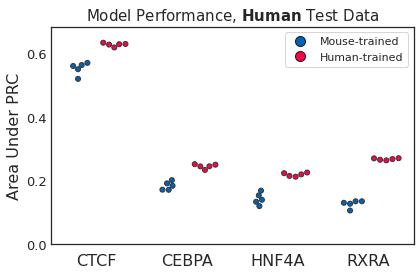

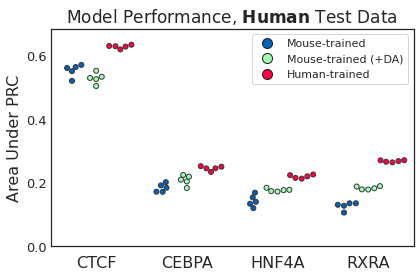

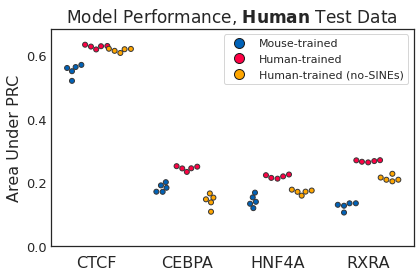

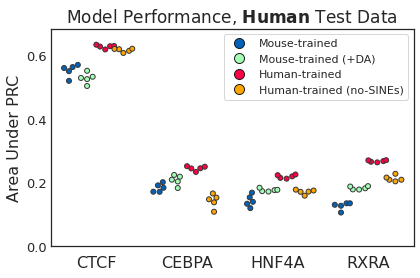

In [9]:
# listing out all the groups of model types (training species)
# to make plots with
include_list_all = [
    ["mm10", "hg38"],
    ["mm10", "DA", "hg38"],
    ["mm10", "NS", "hg38"]
]


for index, include_list in enumerate(include_list_all):
    sns.set(rc = {'figure.figsize' : FIG_SIZE})
    plt.figure(index)
    make_boxplot(human_test_df, "hg38", save_files = True, include = include_list)

## Mouse Test Set

In [10]:
all_preds_mouse_test = load_all_test_set_preds("mm10")

=== CTCF, mm10-trained ===
=== CEBPA, mm10-trained ===
=== Hnf4a, mm10-trained ===
=== RXRA, mm10-trained ===
=== CTCF, DA-trained ===
=== CEBPA, DA-trained ===
=== Hnf4a, DA-trained ===
=== RXRA, DA-trained ===
=== CTCF, hg38-trained ===
=== CEBPA, hg38-trained ===
=== Hnf4a, hg38-trained ===
=== RXRA, hg38-trained ===
=== CTCF, NS-trained ===
=== CEBPA, NS-trained ===
=== Hnf4a, NS-trained ===
=== RXRA, NS-trained ===


In [11]:
mouse_test_df = get_auPRC_df(all_preds_mouse_test, "mm10")

mouse_test_df.to_csv(ROOT + "plots/mm10_test_all_auPRCs.csv")

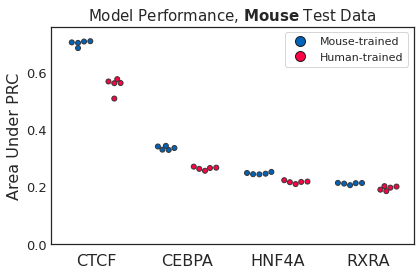

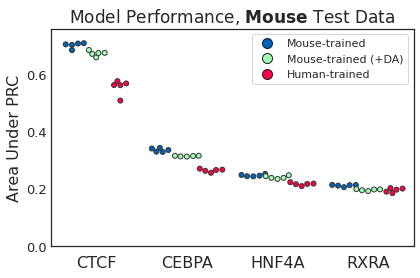

In [12]:
# Generate plots for performance on MOUSE test data
include_list_all = [
    ["mm10", "hg38"],
    ["mm10", "DA", "hg38"]
]

for index, include_list in enumerate(include_list_all):
    sns.set(rc = {'figure.figsize' : FIG_SIZE})
    plt.figure(index)
    make_boxplot(mouse_test_df, "mm10", save_files = True, include = include_list)    